In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_auc_score
import scipy.stats as st
from scipy.stats import norm, skew #for some statistics

In [3]:
train = pd.read_csv(r'F:\DataSets\Kaggle_HousingPriceCompitition\train.csv')
test = pd.read_csv(r'F:\DataSets\Kaggle_HousingPriceCompitition\test.csv')

In [4]:
train.shape

(1460, 81)

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


# Data Processing
#Outliers

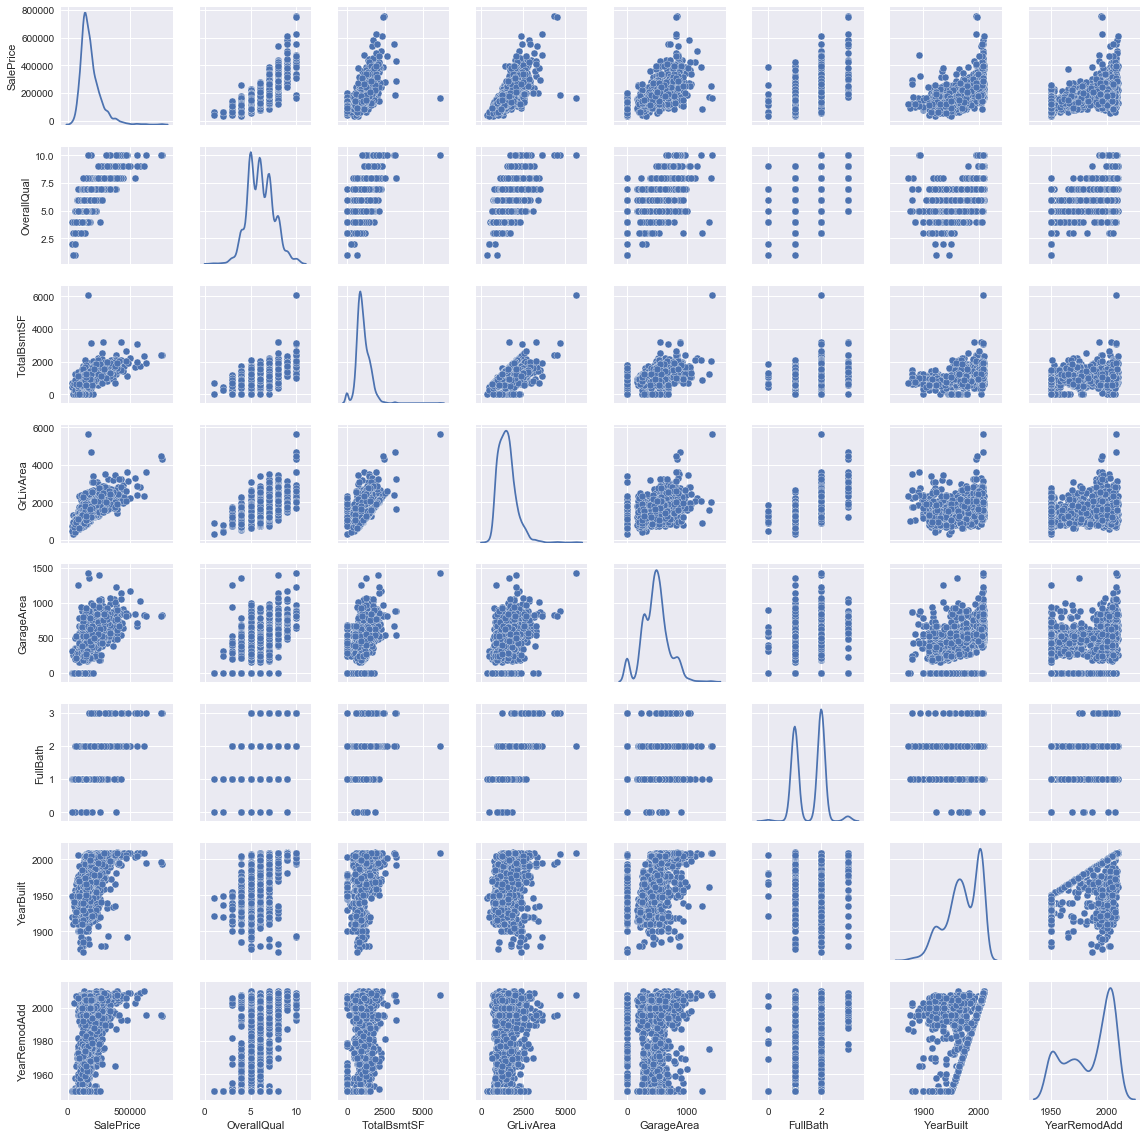

In [7]:
sns.set()
columns = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageArea','FullBath','YearBuilt','YearRemodAdd']
sns.pairplot(train[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

# Finding & Deleting Outliers

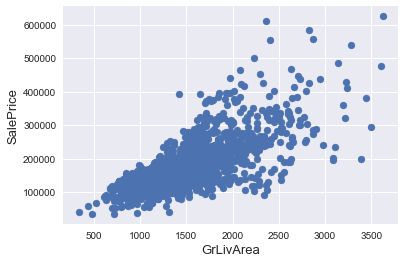

In [8]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']>150000)].index)
train = train.drop(train[(train['TotalBsmtSF']>5000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<200000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
#ax.scatter(train['TotalBsmtSF'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# Features engineering
let's first concatenate the train and test data in the same dataframe

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2913, 79)


# Data Correlation

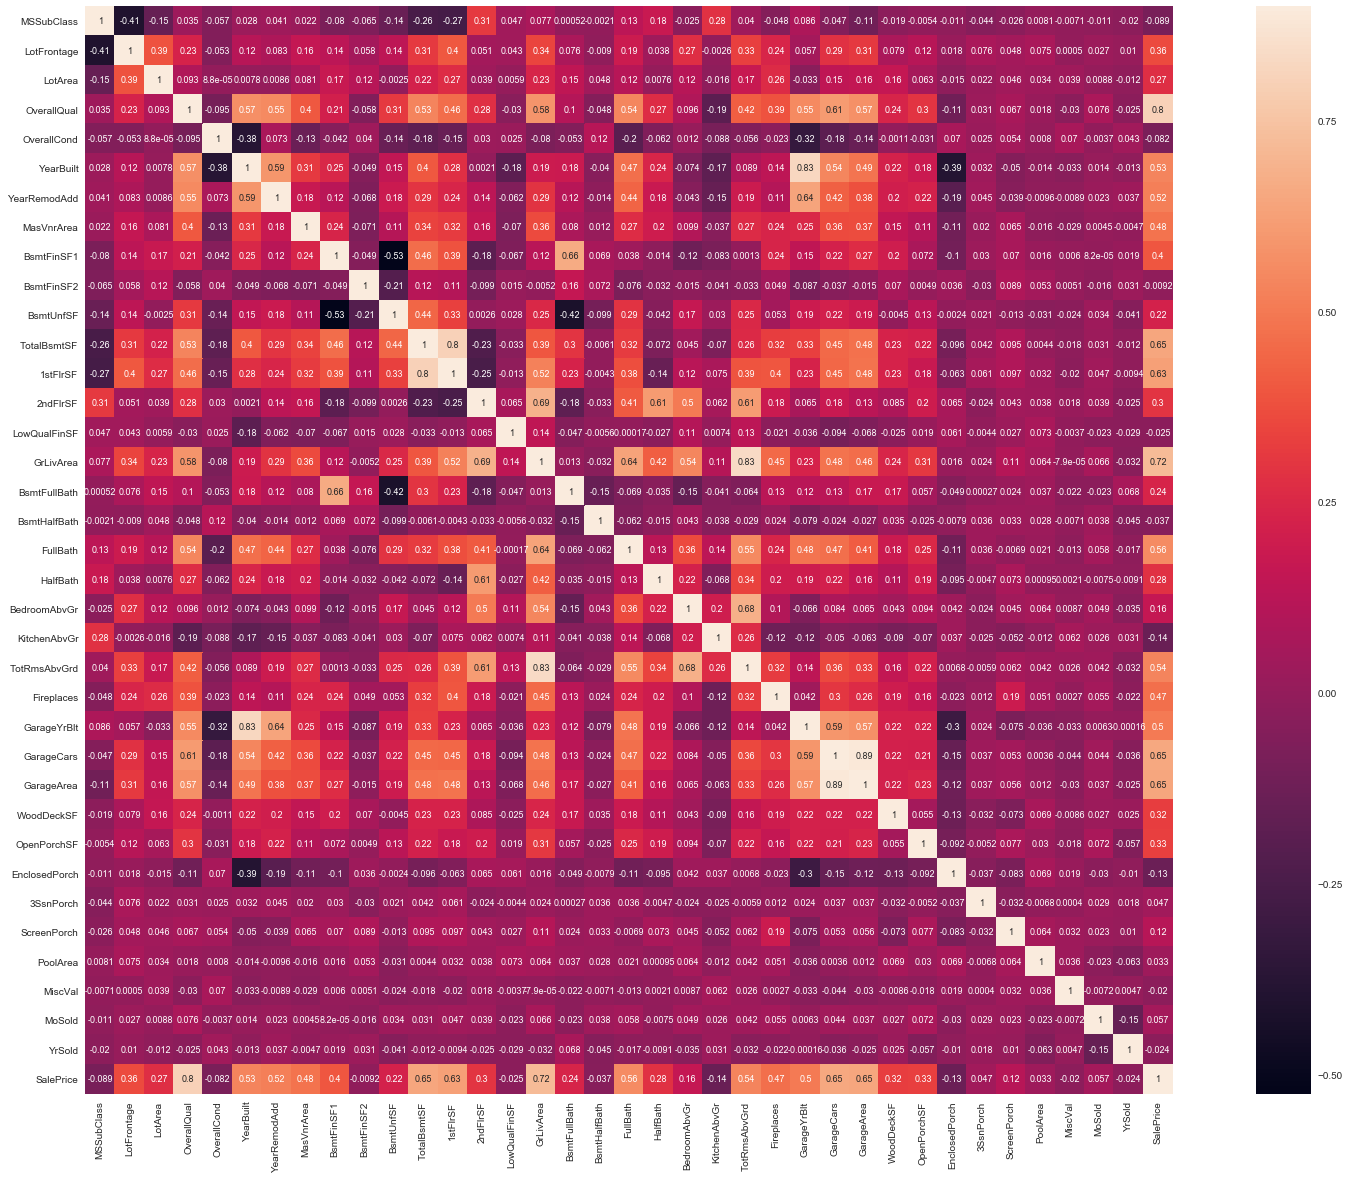

In [10]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(30,20))
sns.heatmap(corrmat, vmax=0.9, annot=True, annot_kws = {'size':9}, square=True)

drop the highly corelated columns


In [11]:
#Drop the columns according to map above:
#TotRmsAbvGrd & 1stFlrSF have higher correlation among themselves.

all_data.drop(['TotRmsAbvGrd'], axis=1, inplace=True)

In [19]:
#GarageCars & GarageArea have higher correlation among themselves.
all_data.drop(['GarageCars'], axis=1, inplace=True)

In [12]:
#PoolQC : data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

In [13]:
#MiscFeature : data description says NA means "no misc feature"
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

In [14]:
#data description says NA means "no alley access"
all_data["Alley"] = all_data["Alley"].fillna("None")


In [15]:
#Fence : data description says NA means "no fence"
all_data["Fence"] = all_data['Fence'].fillna("None")

In [16]:
#FireplaceQu : data description says NA means "no fireplace"
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [17]:
#LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [18]:
#GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [20]:
#GarageYrBlt, GarageArea : Replacing missing data with 0.
for col in ('GarageYrBlt','GarageArea'):
    all_data[col] = all_data[col].fillna(0)

In [21]:
#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF,TotalBsmtSF,BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [22]:
#BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [23]:
#MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [24]:
#MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [25]:
#Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
all_data = all_data.drop(['Utilities'], axis=1)

In [26]:
#Functional : data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

#Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

#KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

#Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

#SaleType : Fill in again with most frequent which is "WD"
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

#MSSubClass : Na most likely means No building class. We can replace missing values with None
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [27]:
#Is there any remaining missing value ?
all_data.isnull().sum()

1stFlrSF         0
2ndFlrSF         0
3SsnPorch        0
Alley            0
BedroomAbvGr     0
BldgType         0
BsmtCond         0
BsmtExposure     0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtFinType1     0
BsmtFinType2     0
BsmtFullBath     0
BsmtHalfBath     0
BsmtQual         0
BsmtUnfSF        0
CentralAir       0
Condition1       0
Condition2       0
Electrical       0
EnclosedPorch    0
ExterCond        0
ExterQual        0
Exterior1st      0
Exterior2nd      0
Fence            0
FireplaceQu      0
Fireplaces       0
Foundation       0
FullBath         0
                ..
LotArea          0
LotConfig        0
LotFrontage      0
LotShape         0
LowQualFinSF     0
MSSubClass       0
MSZoning         0
MasVnrArea       0
MasVnrType       0
MiscFeature      0
MiscVal          0
MoSold           0
Neighborhood     0
OpenPorchSF      0
OverallCond      0
OverallQual      0
PavedDrive       0
PoolArea         0
PoolQC           0
RoofMatl         0
RoofStyle        0
SaleConditio

# More Feature Engineering

In [28]:
#Transforming some numerical variables that are really categorical

#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Label Encoding some categorical variables

In [29]:

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))


Shape all_data: (2913, 76)


In [30]:
#Adding one more important feature

#Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

# Adding total sqfootage feature 

all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Check For Highly skewed features:

In [31]:
numeric_feature = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feature].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


Skew in numerical features: 



,Skew
MiscVal,21.934376
PoolArea,18.695357
LotArea,13.177218
LowQualFinSF,12.076090
3SsnPorch,11.364106
LandSlope,4.991687
KitchenAbvGr,4.297140
BsmtFinSF2,4.141222
EnclosedPorch,3.999248
ScreenPorch,3.941914


In [32]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 57 skewed numerical features to Box Cox transform



 mu = 180227.78 and sigma = 76678.19



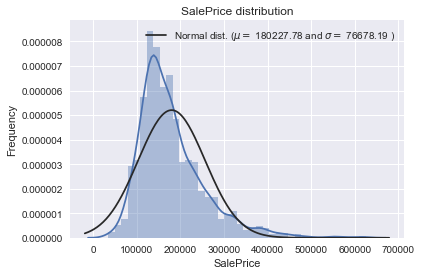

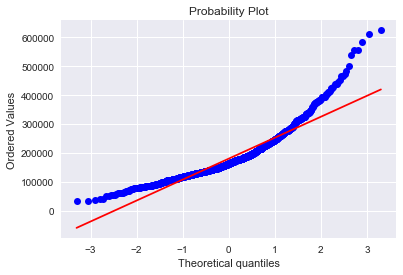

In [33]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = st.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



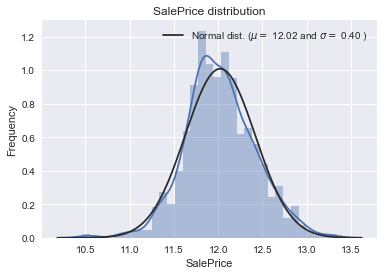

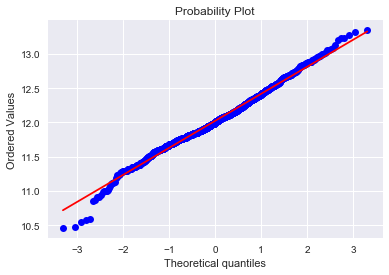

In [34]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = st.probplot(train['SalePrice'], plot=plt)
plt.show()

# Getting dummy categorical features

In [35]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2913, 218)


In [36]:
#Getting the new train and test sets.

train = all_data[:ntrain]
test = all_data[ntrain:]

# Linear Regression

In [43]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
lm.fit(train,y_train)
y2_predict = lm.predict(test)

lm.score(train,y_train)

acc_lm = round(lm.score(train, y_train) * 100, 2)
print("n = ", round(acc_lm,2,), "%")

('n = ', 91.36, '%')


# Random Forest

In [40]:
#def RF(train, test, y_train, n):
random_forest = RandomForestRegressor(n_estimators=500)
random_forest.fit(train, y_train)

y_predict = random_forest.predict(test)

random_forest.score(train, y_train)
acc_random_forest = round(random_forest.score(train, y_train) * 100, 2)
print("n = ", round(acc_random_forest,2,), "%")
    
    #return y_predict

('n = ', 98.52, '%')


# Additional - Cross Validation Strategy

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [42]:
GBoost.fit(train, y_train)

y1_predict = GBoost.predict(test)

GBoost.score(train, y_train)
acc_GBoost = round(GBoost.score(train, y_train) * 100, 2)
print("n = ", round(acc_GBoost,2,), "%")
    

('n = ', 98.91, '%')



# write result into csv file

In [44]:
#Write the prediction file in to csv format
my_submission = pd.DataFrame({'Id': test_ID, 'SalePrice': y_predict})

# you could use any filename. We choose submission here
my_submission.to_csv('C:\Users\Mangesh\Desktop\submission.csv', index=False, header=True)